In [1]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, BertModel, BertForSequenceClassification, BertTokenizer
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Concatenate, GlobalAveragePooling1D
from keras import backend as K
import torch
from torchsummary import summary
import tensorflow as tf
import datasets
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from time import time
import copy
import gc

# Training of the ITE model

## Loading the embeddings as the inputs and the ITE as the target

In [2]:
sent_fact_outs = np.load('outs/counterfactuals/sent_fact_outs.npy')
gen_fact_outs = np.load('outs/counterfactuals/gen_fact_outs.npy')
conc_fact = np.concatenate([sent_fact_outs,gen_fact_outs],axis=1)
print(conc_fact.shape)

#Copying the factuals in order to have one for each counterfactual.
n_cf = 5
fact_n_cf = [] 
for i in range(len(conc_fact)):
    for j in range(n_cf):
        fact_n_cf.append(conc_fact[i])
fact_n_cf = np.array(fact_n_cf)

(3127, 1536)


In [3]:
ITE_peace = np.load('outs/counterfactuals/ITE_peace.npy')

## Training the model to evaluate the regression

In [4]:
def rmse_keras(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [5]:
def mse(y_true, y_pred):
        return np.mean(np.square(y_true - y_pred))

In [4]:
n_avg = 10

In [6]:
fact_train,fact_test,ITE_train,ITE_test = train_test_split(fact_n_cf,ITE_peace,test_size=0.3,random_state=42)

In [7]:
print(fact_n_cf.shape)
print(fact_train.shape)
print(fact_test.shape)

(15635, 1536)
(10944, 1536)
(4691, 1536)


In [9]:
ITE_pred_train = []
ITE_pred_test = []
for i in range(n_avg):
    ITE_model = Sequential([
              Flatten(),
              Dense(128, activation='relu'),
              Dense(64, activation='relu'),
              Dense(1, activation='tanh')
          ])
    ITE_model.compile(optimizer='adam', loss="mean_squared_error")
    ITE_model.fit(fact_train,ITE_train,epochs=20,batch_size=32,validation_split=0.1)
    ITE_pred_train.append(np.squeeze(ITE_model.predict(fact_train)))
    ITE_pred_test.append(np.squeeze(ITE_model.predict(fact_test)))
ITE_pred_train = np.mean(ITE_pred_train,axis=0)
ITE_pred_test = np.mean(ITE_pred_test,axis=0)

Epoch 1/20
308/308 [==============================] - 1s 2ms/step - loss: 0.0701 - val_loss: 0.0534
Epoch 2/20
308/308 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0518
Epoch 3/20
308/308 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0514
Epoch 4/20
308/308 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0466
Epoch 5/20
308/308 [==============================] - 1s 2ms/step - loss: 0.0407 - val_loss: 0.0437
Epoch 6/20
308/308 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0440
Epoch 7/20
308/308 [==============================] - 1s 2ms/step - loss: 0.0376 - val_loss: 0.0457
Epoch 8/20
308/308 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0437
Epoch 9/20
308/308 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0423
Epoch 10/20
308/308 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0398

In [10]:
print("MSE train:",mse(ITE_train,ITE_pred_train))
print("MSE test:",mse(ITE_test,ITE_pred_test))

MSE train: 0.021737048
MSE test: 0.0344448


## Training the model with all the data (train and test sets)

In [5]:
best_val_loss = np.inf
best_ITE_model = None
ITE_pred_fact = []
for i in range(n_avg):
    ITE_model = Sequential([
              Flatten(),
              Dense(128, activation='relu'),
              Dense(64, activation='relu'),
              Dense(1, activation='tanh')
          ])
    ITE_model.compile(optimizer='adam', loss="mean_squared_error")
    history = ITE_model.fit(fact_n_cf,ITE_peace,epochs=25,batch_size=32,validation_split=0.1)
    ITE_pred_fact.append(np.squeeze(ITE_model.predict(conc_fact)))
    
    # Get the last validation loss
    last_val_loss = history.history['val_loss'][-1]
    # Compare with the best validation loss
    if last_val_loss < best_val_loss:
        best_val_loss = last_val_loss
        best_ITE_model = ITE_model

ITE_pred_fact = np.mean(ITE_pred_fact,axis=0)

Epoch 1/25
440/440 [==============================] - 1s 2ms/step - loss: 0.0851 - val_loss: 0.0707
Epoch 2/25
440/440 [==============================] - 1s 2ms/step - loss: 0.0525 - val_loss: 0.0624
Epoch 3/25
440/440 [==============================] - 1s 2ms/step - loss: 0.0466 - val_loss: 0.0614
Epoch 4/25
440/440 [==============================] - 1s 1ms/step - loss: 0.0425 - val_loss: 0.0626
Epoch 5/25
440/440 [==============================] - 1s 1ms/step - loss: 0.0397 - val_loss: 0.0816
Epoch 6/25
440/440 [==============================] - 1s 1ms/step - loss: 0.0375 - val_loss: 0.0648
Epoch 7/25
440/440 [==============================] - 1s 1ms/step - loss: 0.0360 - val_loss: 0.0658
Epoch 8/25
440/440 [==============================] - 1s 1ms/step - loss: 0.0341 - val_loss: 0.0638
Epoch 9/25
440/440 [==============================] - 1s 1ms/step - loss: 0.0340 - val_loss: 0.0614
Epoch 10/25
440/440 [==============================] - 1s 1ms/step - loss: 0.0324 - val_loss: 0.0652

In [6]:
best_ITE_model.save('ITE_model/models/ITE_model')

INFO:tensorflow:Assets written to: ITE_model/models/ITE_model\assets


## Average ITE of the factuals

In [7]:
print("Average ITE:",np.mean(ITE_pred_fact))

Average ITE: 0.29208893


<Axes: >

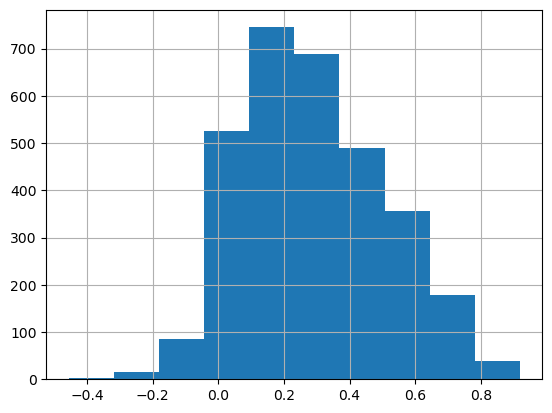

In [8]:
pd.Series(ITE_pred_fact).hist()

# Training a PEACE model with all our training data

## Load Embeddings

In [14]:
frenk_sent_train = np.load('outs/frenk/sent_train_outs.npy')
frenk_aggr_train = np.load('outs/frenk/aggr_train_outs.npy')
frenk_gen_train = np.load('outs/frenk/gen_train_outs.npy')

frenk_sent_test = np.load('outs/frenk/sent_test_outs.npy')
frenk_aggr_test = np.load('outs/frenk/aggr_test_outs.npy')
frenk_gen_test = np.load('outs/frenk/gen_test_outs.npy')

In [15]:
ghc_sent_train = np.load('outs/ghc/sent_train_outs.npy')
ghc_aggr_train = np.load('outs/ghc/aggr_train_outs.npy')
ghc_gen_train = np.load('outs/ghc/gen_train_outs.npy')

ghc_sent_test = np.load('outs/ghc/sent_test_outs.npy')
ghc_aggr_test = np.load('outs/ghc/aggr_test_outs.npy')
ghc_gen_test = np.load('outs/ghc/gen_test_outs.npy')

In [16]:
try_sent_train = np.load('outs/try/sent_train_outs.npy')
try_aggr_train = np.load('outs/try/aggr_train_outs.npy')
try_gen_train = np.load('outs/try/gen_train_outs.npy')

try_sent_test = np.load('outs/try/sent_test_outs.npy')
try_aggr_test = np.load('outs/try/aggr_test_outs.npy')
try_gen_test = np.load('outs/try/gen_test_outs.npy')

In [17]:
sent_train = np.concatenate([frenk_sent_train,frenk_sent_test,ghc_sent_train,ghc_sent_test,try_sent_train,try_sent_test],axis=0)
aggr_train = np.concatenate([frenk_aggr_train,frenk_aggr_test,ghc_aggr_train,ghc_aggr_test,try_aggr_train,try_aggr_test],axis=0)
gen_train = np.concatenate([frenk_gen_train,frenk_gen_test,ghc_gen_train,ghc_gen_test,try_gen_train,try_gen_test],axis=0)

In [18]:
conc_train = np.concatenate([sent_train,aggr_train,gen_train],axis=1)

## Load Labels

In [19]:
#FRENK dataset
df_train = pd.read_csv('data/frenk_train.tsv',sep='\t')
frenk_label_train = df_train["label"].to_numpy()

df_test = pd.read_csv('data/frenk_test.tsv',sep='\t')
frenk_label_test = df_test["label"].to_numpy()

In [20]:
def get_hate_labels(labels):
    hate_labels = np.zeros(len(labels))
    for i in range(len(labels)):
        if labels[i].any():
            hate_labels[i] = 1
    return hate_labels

In [21]:
#Gab dataset
df_train = pd.read_csv('data/ghc_train_8404.tsv',sep='\t')
labels = df_train[["hd","cv"]].to_numpy()
ghc_label_train = get_hate_labels(labels)

df_test = pd.read_csv('data/ghc_test_2301.tsv',sep='\t')
labels = df_test[["hd","cv"]].to_numpy()
ghc_label_test = get_hate_labels(labels)

In [22]:
#Twi-Red-You dataset
df_train = pd.read_csv('data/try_train_8404.tsv',sep='\t')
try_label_train = df_train['hate'].to_numpy()

df_test = pd.read_csv('data/try_test_2301.tsv',sep='\t')
try_label_test = df_test['hate'].to_numpy()

In [23]:
label_train = np.concatenate([frenk_label_train,frenk_label_test,ghc_label_train,ghc_label_test,try_label_train,try_label_test])

In [24]:
c_weights = compute_class_weight('balanced', classes=np.unique(label_train), y=label_train)
c_weights = {0:c_weights[0], 1:c_weights[1]}

## Training the PEACE model

In [25]:
best_val_acc = 0
best_hate_model = None
for i in range(n_avg):
    hate_model = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = hate_model.fit(conc_train, label_train, class_weight=c_weights, epochs=10, batch_size=32, validation_split=0.1)
    #class_weight=c_weights
    
    # Get the last accuracy
    last_val_acc = history.history['val_accuracy'][-1]
    # Compare with the best accuracy
    if last_val_acc > best_val_acc:
        best_val_acc = last_val_acc
        best_hate_model = hate_model

Epoch 1/10
904/904 [==============================] - 4s 4ms/step - loss: 0.5212 - accuracy: 0.7232 - val_loss: 0.7869 - val_accuracy: 0.5374
Epoch 2/10
904/904 [==============================] - 4s 4ms/step - loss: 0.4909 - accuracy: 0.7387 - val_loss: 0.5246 - val_accuracy: 0.7232
Epoch 3/10
904/904 [==============================] - 4s 4ms/step - loss: 0.4790 - accuracy: 0.7446 - val_loss: 0.5292 - val_accuracy: 0.7217
Epoch 4/10
904/904 [==============================] - 5s 6ms/step - loss: 0.4680 - accuracy: 0.7482 - val_loss: 0.6157 - val_accuracy: 0.6747
Epoch 5/10
904/904 [==============================] - 4s 4ms/step - loss: 0.4607 - accuracy: 0.7506 - val_loss: 0.4979 - val_accuracy: 0.7388
Epoch 6/10
904/904 [==============================] - 4s 4ms/step - loss: 0.4480 - accuracy: 0.7568 - val_loss: 0.5992 - val_accuracy: 0.6734
Epoch 7/10
904/904 [==============================] - 5s 6ms/step - loss: 0.4370 - accuracy: 0.7601 - val_loss: 0.5649 - val_accuracy: 0.6912
Epoch 

In [26]:
best_hate_model.save('ITE_model/models/PEACE_model')

INFO:tensorflow:Assets written to: ITE_model/models/PEACE_model\assets
